# 1. Introduction

In this section, we will statistically analysis the Toronto Airbnb dataset.  

The objectives of this section are:
1. To evaluate the statistical properties of the variables;
2. To identify correlation among variables;
3. To identify correlation between the dependent variables and the independent variables.

In [3]:
# import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, mannwhitneyu

%matplotlib inline
pd.set_option('max_columns',500)

C:\Users\georg\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
#import data and preliminary preprocessing
df = pd.read_csv('data/df_cleaned.csv')

#remove data with price = 0
index = df[df.price == 0].index
for idx in index:
    df.drop(idx, axis=0, inplace=True)

# 2. Price Distribution 

As discussed in the previous section, the price distribution is highly right skewed due to the presence of outliers.  As such, log transformation is applied to normalize the data.

In [5]:
df['log_price'] = np.log(df.price)

Text(0.5,1,'Q-Q plot of price')

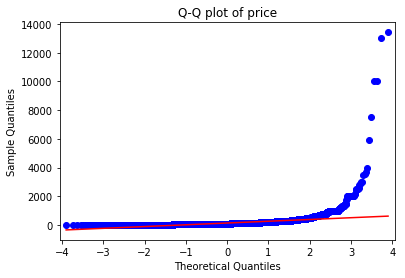

In [6]:
sm.qqplot(df.price,line='r')
plt.title('Q-Q plot of price')

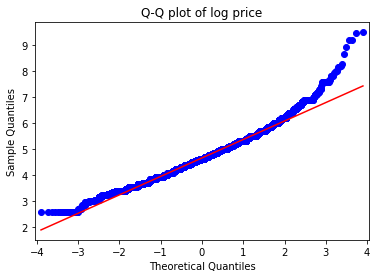

In [7]:
sm.qqplot(df.log_price,line='r')
plt.title('Q-Q plot of log price');

We can see that the while the data is still right skewed after log transformation, it is considerably more normal than the original data. As such, log price will be used as the target variable.

# 3. Relationship bewteen of Price with Features

Next, we look at the correlation between price and the other quantative variables. The quantative variables will be grouped according to their categories.

## 3.1 Property Characteristics

### 3.1.1 Numerical features

Features that belong to this category are:  
- accommodates, bathrooms, bedrooms, beds

''

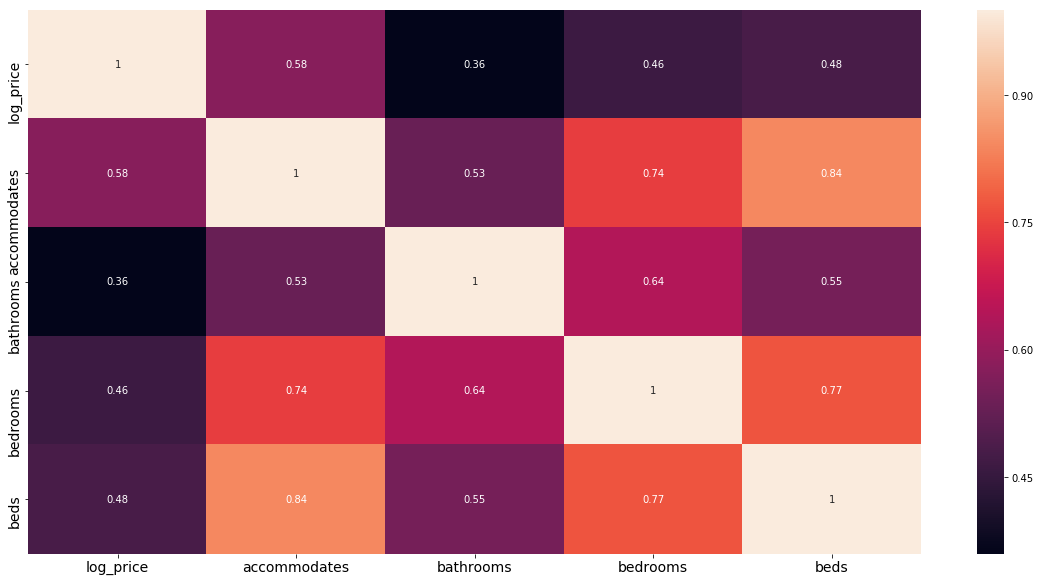

In [13]:
plt.figure(figsize=(20,10))
corr_matrix = df[['log_price','accommodates', 'bathrooms', 'bedrooms', 'beds']].corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.tick_params(labelsize=14)
;

All four features are correlated with log price. Also, accommodates, bedrooms, and number of beds are highly correlated as expected. The number of bathrooms are also correlated with the other features. 

### 3.1.2 Categorical Features

Features that belong to this category are:  
- property_type,room_type, bed_type, city_fsa

Since the log price is not normal, the Mann Whitney U (MWU) test will be used for features with binary response (1/0, or t/f, etc), where Kruskal-Wallis (KW) test will be used for multi-category response. The hypothesis tested by both MWU test and KW test is whether the samples from the different categories are taken from the same population. If they are not, then the feature may be of use to predict the price.  

The sample size should > 20 for each sample for the MWU test, and > 5 for each sample for the KW test.

(Reference: [Mann Whitney U Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [Kruskal-Wallis H Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html))

First, for property type, two feature enginnering steps are performed prior to the analysis. 
1. As discussed in the last section, a bungalow is in reality a house, so all 'Bungalow' are assigned to the 'House' category.
2. The three major categories are House, Apartment and Condominium. The rest will be assigned to the 'Other' category.

In [22]:
df.loc[df.property_type == 'Bungalow','property_type'] = 'House'
df['property_type_simple'] = df.property_type.apply(lambda x: 'Other' if x not in ['House','Apartment','Condominium'] else x)

In [29]:
def pop_eval(feature_list,threshold = 20):

    for feature in feature_list:
        filter_ = (df[feature].value_counts() > threshold)
        data_list = []
        var_str = ""
        cat_list = df[feature].value_counts()[filter_].index
        for i, cat in enumerate(cat_list):
            data_list.append(list(df.loc[df[feature] == cat, 'log_price'].values))
            var_str = var_str + 'data_list' + "[" + str(i) + "]" + ", "
        var_str = var_str[:-2]
        if len(cat_list) > 2:
            s, p = eval('kruskal(' + var_str + ')')
        elif len(cat_list) == 2:
            s, p = eval('mannwhitneyu('+ var_str + ')')
            
        print(f'Feature: {feature}')
        print(f'Categories: {list(cat_list)}')
        if len(cat_list) ==1:
            print(f'Only one category has count above the threshold of {threshold}. No test was performed.')
            break
        if len(cat_list) > 2:
            print('Test: Kruskal-Wallis Test')
        elif len(cat_list) == 2:
            print('Test: Mann Whitney U Test')
        print(f'The test statistics is {s} and the p-value is {p}.')
        if p < 0.05:
            print('Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.')
        else:
            print('Null hypothesis NOT rejected. There is not significant evidence the samples are not from the same distribution.')
        print('\n')

In [23]:
pop_eval(['property_type_simple', 'room_type', 'bed_type', 'city_fsa'])

Feature: property_type_simple
Categories: ['House', 'Apartment', 'Condominium', 'Other']
Test: Kruskal-Wallis Test
The test statistics is 2314.6082602423744 and the p-value is 0.0.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: room_type
Categories: ['Entire home/apt', 'Private room', 'Shared room']
Test: Kruskal-Wallis Test
The test statistics is 8749.140153026688 and the p-value is 0.0.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: bed_type
Categories: ['Real Bed', 'Futon', 'Pull-out Sofa']
Test: Kruskal-Wallis Test
The test statistics is 92.26221597070852 and the p-value is 9.236647244876668e-21.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: city_fsa
Categories: ['Downtown Toronto', 'West Toronto', 'North York', 'Central Toronto', 'Scarborough', 'Etobicoke', 'East Toro

The log price for four features are not from the same population. As such, we can expect that they can be useful features in predicting the price of listings. 

## 3.2 Booking policy

### 3.2.1 Numerical Features

Features that belong to this categories are:
- security_deposit, cleaning_fee, guest_included, extra_people, minimum_nights, maximum_nights

In [1]:
plt.figure(figsize=(20,10))
corr_matrix = df[['log_price','security_deposit', 'cleaning_fee','guests_included', 'extra_people',
                  'minimum_nights', 'maximum_nights']].corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.tick_params(labelsize=14);

NameError: name 'plt' is not defined

Log price is correlated with cleaning fee, and moderately correlated with security deposit and the number of guests included.  
We can also see that cleaning fee is positively correlated with the number of guests included.  Cleaning fee is also correlated with security deposit.m

### 3.2.2 Categorical Features

Features that belong to this category are:
- cancellation_policy, instant_bookable, is_business_travel_ready

In [28]:
pop_eval(['cancellation_policy','instant_bookable','is_business_travel_ready'])

Feature: cancellation_policy
Categories: ['strict_14_with_grace_period', 'moderate', 'flexible']
Test: Kruskal-Wallis Test
The test statistics is 637.9253450011881 and the p-value is 2.994135150955425e-139.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: instant_bookable
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 46644410.0 and the p-value is 6.88797289609584e-30.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: is_business_travel_ready
Categories: ['f']
Only one category has count above the threshold of 50. No test was performed.


The test suggests the log price samples are from different distribution for both cancellation_policy and instant_bookable categories.

## 3.3 Availability

Features that belong to this categories are:
- availability_30, availability_60, availability_90, availability_365

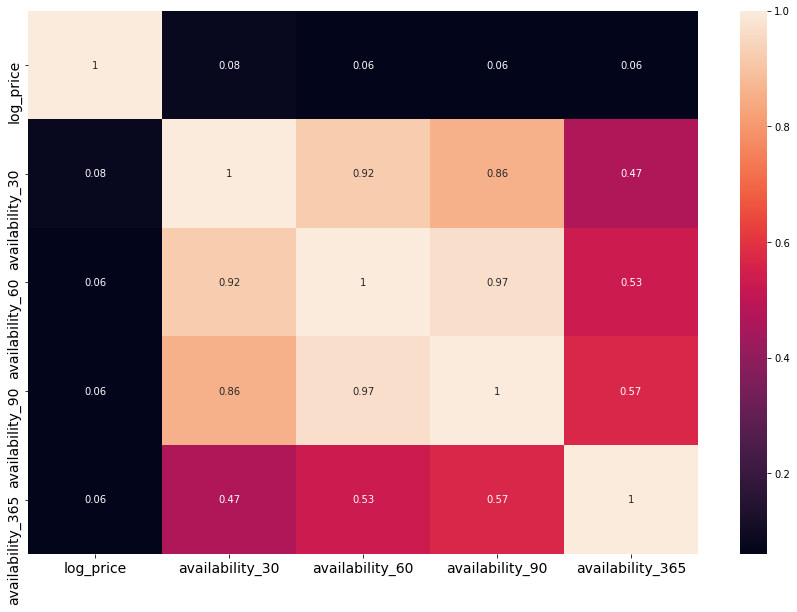

In [39]:
plt.figure(figsize=(15,10))
corr_matrix = df[['log_price','availability_30', 'availability_60', 'availability_90', 'availability_365']].corr().round(2)
sns.heatmap(corr_matrix,annot=True)
plt.tick_params(labelsize=14)

;

Log price is not correlated with availability. The availability for the various day periods are highly correlated.

## 3.4 Review scores rating

Features that fall into this category are:
- review_scores_rating, review_scores_accuracy, review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value

In [2]:
corr_matrix = df[['log_price','number_of_reviews','number_of_reviews_ltm','review_scores_rating', 'review_scores_accuracy', 
                  'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                  'review_scores_value']].corr().round(2)
sns.heatmap(corr_matrix,annot=True)
plt.tick_params(labelsize=14)
;

NameError: name 'df' is not defined

Log price is not correlated with number of reviews.

Also, interestingly, while the various categories of review scores are highly correlated, log price is not correlated with any of the review score category.

## 3.5 Host characteristics

### 3.5.1 Numerical features

Features that fall into this category are:
- day_since_host_since

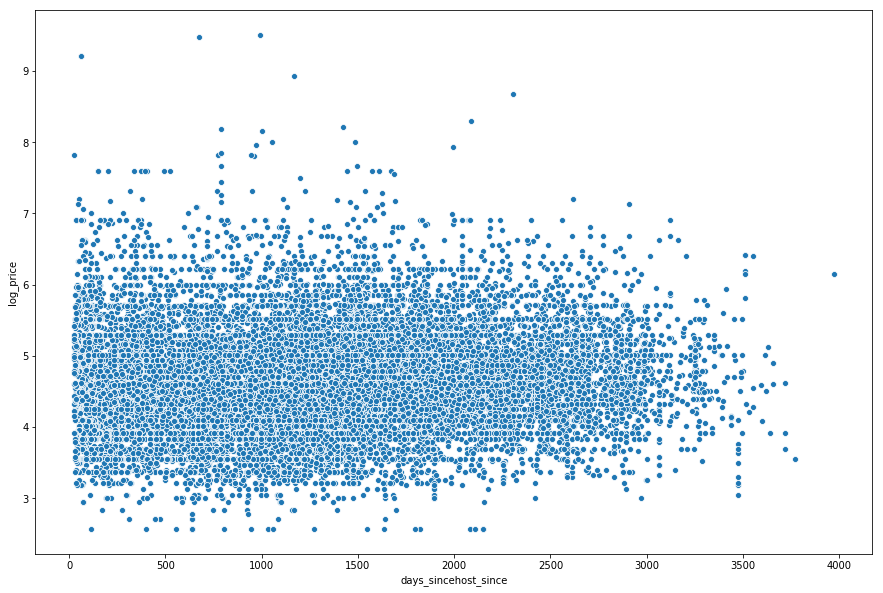

In [34]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x='days_sincehost_since',y='log_price')


The scatterplot shows that the number of days since the host has become host is not related to the log price.

In [224]:
df[['log_price','days_sincehost_since']].corr().round(2)

,log_price,days_sincehost_since
log_price,1.00,0.08
days_sincehost_since,0.08,1.00


There is little correlation between log price and the number of days since the host has become host. 

### 3.5.2 Categorical Features

Features that fall into this category are:
- host_response_time, host_is_superhost, host_has_profile_pic, host_identify_verified 

In [230]:
pop_eval(['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified'])

Feature: host_response_time
Categories: ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
Test: Kruskal-Wallis Test
The test statistics is 32.45526716491811 and the p-value is 4.1958732964670803e-07.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_is_superhost
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 38905079.0 and the p-value is 7.332451283755274e-13.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_has_profile_pic
Categories: ['t', 'f']
Test: Mann Whitney U Test
The test statistics is 449534.0 and the p-value is 0.011320806031015866.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_identity_verified
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 48577980.5 and the p-value is 0.0

It is interesting to see that the log price are not from the same population for all of the above features. 

## 3.6 Amenities

Overall, 196 distinct amenities are included in all the listings. For this analysis, we will choose the amenities that are not too rare or too common. Thresholds between 30% and 70% are chosen; i.e. amenities that are present between 30% and 70% of listings are chosen.

In [41]:
amenities_list = [x for x in df.columns if 'amenities' in x]
lower = df.shape[0] * 0.3
upper = df.shape[0] * 0.7
filter_ = (df[amenities_list].sum() <=  upper) & (df[amenities_list].sum() >=  lower)
amenities_test = df[amenities_list].sum()[filter_].index

The amenities that are included in the list are:

In [42]:
print(list(amenities_test))

['amenities_refrigerator', 'amenities_family/kid friendly', 'amenities_dishes and silverware', 'amenities_stove', 'amenities_cooking basics', 'amenities_coffee maker', 'amenities_fire extinguisher', 'amenities_microwave', 'amenities_private entrance', 'amenities_free parking on premises', 'amenities_gym', 'amenities_first aid kit', 'amenities_lock on bedroom door', 'amenities_long term stays allowed', 'amenities_self check-in', 'amenities_oven', 'amenities_bed linens', 'amenities_hot water', 'amenities_elevator']


In [43]:
pop_eval(amenities_test)

Feature: amenities_refrigerator
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 48926506.0 and the p-value is 3.7664462648976347e-26.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: amenities_family/kid friendly
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 35140813.5 and the p-value is 1.9683738134443464e-179.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: amenities_dishes and silverware
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 46246152.0 and the p-value is 7.909849422552318e-49.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: amenities_stove
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 44919188.0 and the p-value is 1.3573129609796422e-65.
Null hypothesis rejected. There is significan

With the except of first aid kid, the null hypothesis is rejected for all other amenities, i.e. the log price sample are from different distributions for the two categories for each feature.

# 4. Conclusions

In this exercise, we used statistical methods to evaluate the data set.

* The price is highly right skewed due to outliers with high prices. After log transformation, the price is still right skewed but appears more normal. 

* The following numerical features are found to be correlated with log price:
    * accommodates 
    * bedroom
    * bathroom
    * beds
    * security deposit
    * cleaning fee


* The following categorical features could be useful to predict log price:
    * property type
    * room type
    * bed type
    * city
    * cancellationpolicy
    * instant bookable
    * host response time
    * superhost status
    * host has profile pic
    * host identity verified
    * amenities - refrigerator
    * amenities - family/kid friendly
    * amenities - dishes and silverware
    * amenities - stove
    * amenities - cooking basics
    * amenities - coffee maker
    * amenities - fire extingusiher
    * amenities - microwave
    * amenities - private entrance
    * amenities - free parking on premises
    * amenities - gym
    * amenities - lock on bedroom door
    * amenities - long term stays allowed
    * amenities - self check-in
    * amenities - oven
    * amenities - bed linens
    * amenities - hot water
    * amenities - elevator